# DATA

In [1]:
# import csv
from tqdm.notebook import tqdm
import numpy as np
from scipy import sparse
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
        classification_report, 
        confusion_matrix, 
        ConfusionMatrixDisplay,
        precision_recall_fscore_support,
        accuracy_score
    )
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/oscarw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# NLP Preprocessing

1. TF-IDF (Term frequency, inverse-document frequency) --> bag of words (will )
2. pre-trained word embeddings like word2vec, glove, or fastText --> more semantic and dense representation


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@(\w+)', r'\1', text)
    text = re.sub(r'[^a-zA-Z\'\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s*\'\s*', '\'', text)
    return text.strip()

def preprocess(path, vectorizer=None):
    df = pd.read_csv(path)
    
    # Clean the text first
    df["text"] = df["text"].apply(clean_text)
    
    if 'train' in path:
        vectorizer = TfidfVectorizer(
            min_df=5, 
            max_df=0.92,
            ngram_range=(1, 3), 
            stop_words='english',
            lowercase=True,
            strip_accents='unicode',
            token_pattern=r'\b\w+\'?\w*\b',
        )
        tfidf_matrix = vectorizer.fit_transform(df["text"])
        
        print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        print("\nExample features:")
        feature_names = vectorizer.get_feature_names_out()
        print("Unigrams:", ', '.join(feature_names[:5]))
        bigrams = [f for f in feature_names if ' ' in f][:5]
        print("Bigrams/Trigrams:", ', '.join(bigrams))
        
    else:
        tfidf_matrix = vectorizer.transform(df["text"])
    
    X = tfidf_matrix.toarray()
    df = df.drop(columns=['id','text'])
    x_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    
    return pd.concat([df.reset_index(drop=True), x_df.reset_index(drop=True)], axis=1), vectorizer

In [3]:
# OLID datasets
olid_train_df, olid_vectorizer = preprocess('data/olid-train.csv')
olid_test_df, _ = preprocess('data/olid-test.csv', vectorizer=olid_vectorizer)

# HASOC datasets
hasoc_train_df, hasoc_vectorizer = preprocess('data/hasoc-train.csv')
hasoc_test_df, _ = preprocess('data/olid-test.csv', vectorizer=hasoc_vectorizer)

Vocabulary size: 5757

Example features:
Unigrams: aaron, ab, abiding, abiding citizens, abiding nra
Bigrams/Trigrams: abiding citizens, abiding nra, absolutely right, abuse power, act like
Vocabulary size: 4033

Example features:
Unigrams: aajtak, abandoned, abandoned rain, abc, able
Bigrams/Trigrams: abandoned rain, abusing modi, accept foreign, account murderer, activist sabotaging


In [4]:
# OLID
X = olid_train_df.drop('labels', axis=1)
y = olid_train_df['labels']

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# x_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# OLID TEST
X_test = olid_test_df.drop('labels', axis=1)
y_test = olid_test_df['labels']

# x_scaled_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [5]:
# HASOC
X_hasoc = hasoc_train_df.drop('labels', axis=1)
y_hasoc = hasoc_train_df['labels']

# scaler_hasoc = StandardScaler()
# X_scaled_hasoc = scaler_hasoc.fit_transform(X_hasoc)
# x_scaled_hasoc = pd.DataFrame(X_scaled_hasoc, columns=X_hasoc.columns)

X_train_hasoc, X_val_hasoc, y_train_hasoc, y_val_hasoc = train_test_split(X_hasoc, y_hasoc, test_size=0.2, random_state=42, stratify=y_hasoc)

# HASOC TEST
X_test_hasoc = hasoc_test_df.drop('labels', axis=1)
y_test_hasoc = hasoc_test_df['labels']

# x_scaled_test_hasoc = pd.DataFrame(scaler_hasoc.transform(X_test_hasoc), columns=X_test_hasoc.columns)

# SVM

Support Vector Machine (SVM) Model
- maximizing the boundary space between points in space
- loss functions for determining the weights --> Hinge Function
- regularization 

In [6]:
def evaluate_model(y_true, y_pred, class_names=['Class 0', 'Class 1'], label='olid'):
    print("=" * 70)
    print("EVALUATION METRICS")
    print("=" * 70)
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    
    print("\n" + "=" * 70)
    print("CLASSIFICATION REPORT")
    print("=" * 70)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    
    print("=" * 70)
    print("MACRO-AVERAGED METRICS")
    print("=" * 70)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    print(f"Macro-Averaged Precision: {precision_macro:.4f}")
    print(f"Macro-Averaged Recall:    {recall_macro:.4f}")
    print(f"Macro-Averaged F1-Score:  {f1_macro:.4f}")
    
    print("\n" + "=" * 70)
    print("PER-CLASS METRICS")
    print("=" * 70)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )
    
    for i in range(len(class_names)):
        print(f"\n{class_names[i]}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall:    {recall[i]:.4f}")
        print(f"  F1-Score:  {f1[i]:.4f}")
        print(f"  Support:   {support[i]}")
    
    print("\n" + "=" * 70)
    print("CONFUSION MATRIX")
    print("=" * 70)
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nInterpretation:")
    print(f"  True Negatives (TN):  {cm[0, 0]}")
    print(f"  False Positives (FP): {cm[0, 1]}")
    print(f"  False Negatives (FN): {cm[1, 0]}")
    print(f"  True Positives (TP):  {cm[1, 1]}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Confusion Matrix\n(Absolute Counts)', fontsize=12)
    axes[0].grid(False)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=axes[1], cbar_kws={'label': 'Percentage'})
    axes[1].set_title('Confusion Matrix\n(Normalized)', fontsize=12)
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_{label}.png', dpi=300, bbox_inches='tight')
    print(f"\nConfusion matrix for {label} saved as 'confusion_matrix_{label}.png'")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm
    }

In [7]:
class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, random_state=None):
        self.lr = learning_rate
        self.lambda_param = float(lambda_param)
        self.n_iters = int(n_iters)
        self.random_state = random_state
        self.w = None
        self.b = 0.0
        self.losses = []  # OPTIONAL but doing it

    def _as_binary_pm1(self, y):
        return np.where(y > 0.5, 1.0, -1.0).astype(np.float64)

    def _compute_sample_weights(self, y):
        y = np.asarray(y)
        classes, counts = np.unique(y, return_counts=True)
        n_samples = len(y)
        n_classes = len(classes)
        
        class_weights = {cls: n_samples / (n_classes * count) for cls, count in zip(classes, counts)}
        sample_weights = np.array([class_weights[label] for label in y], dtype=np.float64)
        return sample_weights

    def fit(self, X, y):
        if sparse.issparse(X):
            n_samples, n_features = X.shape
        else:
            X = np.asarray(X, dtype=np.float64)
            n_samples, n_features = X.shape

        y = np.asarray(y)
        y_pm1 = self._as_binary_pm1(y)

        sample_weights = self._compute_sample_weights(y)

        rng = np.random.default_rng(self.random_state)
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0

        # Training loop
        for epoch in tqdm(range(self.n_iters), desc='Training SVM'):
            # Compute decision function: f(x) = w^T x + b
            if sparse.issparse(X):
                decision = X.dot(self.w) + self.b
            else:
                decision = X @ self.w + self.b

            # Compute margins: y_i * f(x_i)
            margins = y_pm1 * decision

            # Indicator: 1 if margin < 1 (i.e., hinge loss active)
            hinge_active = (margins < 1.0).astype(np.float64)

            # Gradient for w: 
            # ∇_w = 2λw - (1/n) * Σ [ w_i * y_i * x_i * I(margin < 1) ]
            if sparse.issparse(X):
                grad_w = (2.0 * self.lambda_param * self.w) - (X.T.dot(sample_weights * y_pm1 * hinge_active) / n_samples)
            else:
                grad_w = (2.0 * self.lambda_param * self.w) - (X.T @ (sample_weights * y_pm1 * hinge_active) / n_samples)

            # Gradient for b:
            # ∇_b = - (1/n) * Σ [ w_i * y_i * I(margin < 1) ]
            grad_b = -np.sum(sample_weights * y_pm1 * hinge_active) / n_samples

            # Update parameters
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            # Optional: track average hinge loss for debugging
            hinge_loss = np.maximum(0, 1 - margins)
            weighted_loss = np.mean(sample_weights * hinge_loss) + self.lambda_param * np.dot(self.w, self.w)
            self.losses.append(weighted_loss)

        return self

    def decision_function(self, X):
        """Compute raw decision scores."""
        if sparse.issparse(X):
            return X.dot(self.w) + self.b
        X = np.asarray(X, dtype=np.float64)
        return X @ self.w + self.b

    def predict(self, X):
        """Predict class labels as 0 or 1."""
        scores = self.decision_function(X)
        return (scores >= 0.0).astype(int)

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def tune_svm_hyperparameters(X, y, param_grid, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    results = []
    
    for lr in param_grid['learning_rate']:
        for lam in param_grid['lambda_param']:
            for n_iter in param_grid['n_iters']:
                fold_scores = []
                
                for train_idx, val_idx in kf.split(X):
                    X_train_fold = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
                    X_val_fold = X.iloc[val_idx] if hasattr(X, 'iloc') else X[val_idx]
                    y_train_fold = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
                    y_val_fold = y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]
                    
                    svm = SVM(learning_rate=lr, lambda_param=lam, n_iters=n_iter, random_state=42)
                    svm.fit(X_train_fold, y_train_fold)
                    y_pred = svm.predict(X_val_fold)
                    
                    f1 = f1_score(y_val_fold, y_pred)
                    fold_scores.append(f1)
                
                avg_score = np.mean(fold_scores)
                std_score = np.std(fold_scores)
                
                results.append({
                    'learning_rate': lr,
                    'lambda_param': lam,
                    'n_iters': n_iter,
                    'mean_f1': avg_score,
                    'std_f1': std_score
                })
                
                print(f"LR: {lr}, Lambda: {lam}, Iters: {n_iter} -> F1: {avg_score:.4f} (+/- {std_score:.4f})")
    
    results = sorted(results, key=lambda x: x['mean_f1'], reverse=True)
    return results

In [ ]:
# Define parameter grid with typical ranges

param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'lambda_param': [0.001, 0.01, 0.1],
    'n_iters': [5000, 10000, 15000]
}

# Run grid search
results = tune_svm_hyperparameters(X_train, y_train, param_grid, cv=2)

best_params = results[0]
print(f"\nBest parameters: {best_params}")

In [ ]:
# Run grid search on HASOC
results_hasoc = tune_svm_hyperparameters(X_train_hasoc, y_train_hasoc, param_grid, cv=1)

best_params_hasoc = results_hasoc[0]
print(f"\nBest parameters: {best_params_hasoc}")

# 1

In [ ]:
# OLID Fit
svm = SVM(learning_rate=0.01, lambda_param=0.1, n_iters=5000, random_state=42) # BEST + 15000
svm.fit(X_train.values, y_train.values)

y_pred = svm.predict(X_val.values)
pd.DataFrame(y_pred).describe()

# plot loss
plt.plot(svm.losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Weighted Hinge Loss + L2')
plt.show()

# eval on validation data
accuracy = np.mean(y_pred == y_val.values)
print(f"Accuracy: {accuracy:.2f}")

from sklearn.metrics import f1_score

f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f"Macro F1:    {f1_macro:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")

In [ ]:
# OLID TESTING
y_pred_test = svm.predict(X_test.values)
pd.DataFrame(y_pred_test).describe()
metrics = evaluate_model(y_test, y_pred_test, class_names=['Non-Offensive', 'Offensive'], label='olid')

In [ ]:
# HASOC Fit
svm_hasoc = SVM(learning_rate=0.001, lambda_param=0.1, n_iters=5000, random_state=42)
svm_hasoc.fit(X_train_hasoc.values, y_train_hasoc.values)

y_pred_hasoc = svm_hasoc.predict(X_val_hasoc.values)
pd.DataFrame(y_pred_hasoc).describe()

# plot loss
plt.plot(svm_hasoc.losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Weighted Hinge Loss + L2')
plt.show()

# eval on validation data
accuracy_hasoc = np.mean(y_pred_hasoc == y_val_hasoc.values)
print(f"Accuracy: {accuracy_hasoc:.2f}")

from sklearn.metrics import f1_score

f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f"Macro F1:    {f1_macro:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")

In [ ]:
# OLID TESTING
y_pred_test_hasoc = svm_hasoc.predict(X_test_hasoc.values)
pd.DataFrame(y_pred_test_hasoc).describe()
metrics_hasoc = evaluate_model(y_test_hasoc, y_pred_test_hasoc, class_names=['Non-Offensive', 'Offensive'], label='hasoc')

Training SVM:   0%|          | 0/5000 [00:00<?, ?it/s]

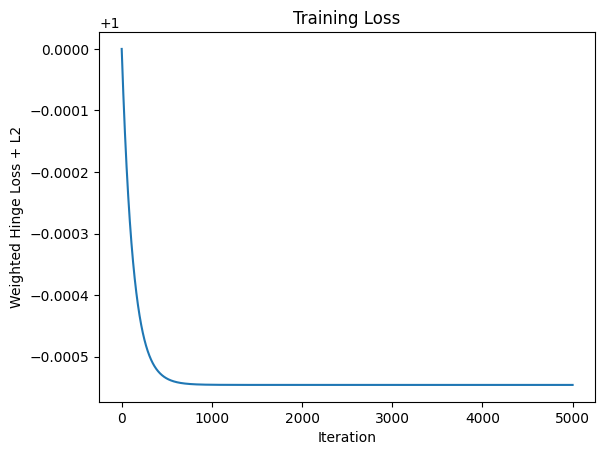

Accuracy: 0.58
Macro F1:    0.5805
Weighted F1: 0.5827


In [9]:
# HASOC Fit
svm_hasoc = SVM(learning_rate=0.005, lambda_param=0.4, n_iters=5000, random_state=42)
svm_hasoc.fit(X_train_hasoc.values, y_train_hasoc.values)

y_pred_hasoc = svm_hasoc.predict(X_val_hasoc.values)
pd.DataFrame(y_pred_hasoc).describe()

# plot loss
plt.plot(svm_hasoc.losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Weighted Hinge Loss + L2')
plt.show()

# eval on validation data
accuracy_hasoc = np.mean(y_pred_hasoc == y_val_hasoc.values)
print(f"Accuracy: {accuracy_hasoc:.2f}")

from sklearn.metrics import f1_score

f1_macro_hasoc = f1_score(y_val_hasoc, y_pred_hasoc, average='macro')
f1_weighted_hasoc = f1_score(y_val_hasoc, y_pred_hasoc, average='weighted')

print(f"Macro F1:    {f1_macro_hasoc:.4f}")
print(f"Weighted F1: {f1_weighted_hasoc:.4f}")

EVALUATION METRICS

Overall Accuracy: 0.4779

CLASSIFICATION REPORT
               precision    recall  f1-score   support

Non-Offensive     0.8327    0.3452    0.4880       620
    Offensive     0.3267    0.8208    0.4674       240

     accuracy                         0.4779       860
    macro avg     0.5797    0.5830    0.4777       860
 weighted avg     0.6915    0.4779    0.4823       860

MACRO-AVERAGED METRICS
Macro-Averaged Precision: 0.5797
Macro-Averaged Recall:    0.5830
Macro-Averaged F1-Score:  0.4777

PER-CLASS METRICS

Non-Offensive:
  Precision: 0.8327
  Recall:    0.3452
  F1-Score:  0.4880
  Support:   620

Offensive:
  Precision: 0.3267
  Recall:    0.8208
  F1-Score:  0.4674
  Support:   240

CONFUSION MATRIX
[[214 406]
 [ 43 197]]

Interpretation:
  True Negatives (TN):  214
  False Positives (FP): 406
  False Negatives (FN): 43
  True Positives (TP):  197

Confusion matrix for hasoc saved as 'confusion_matrix_hasoc.png'


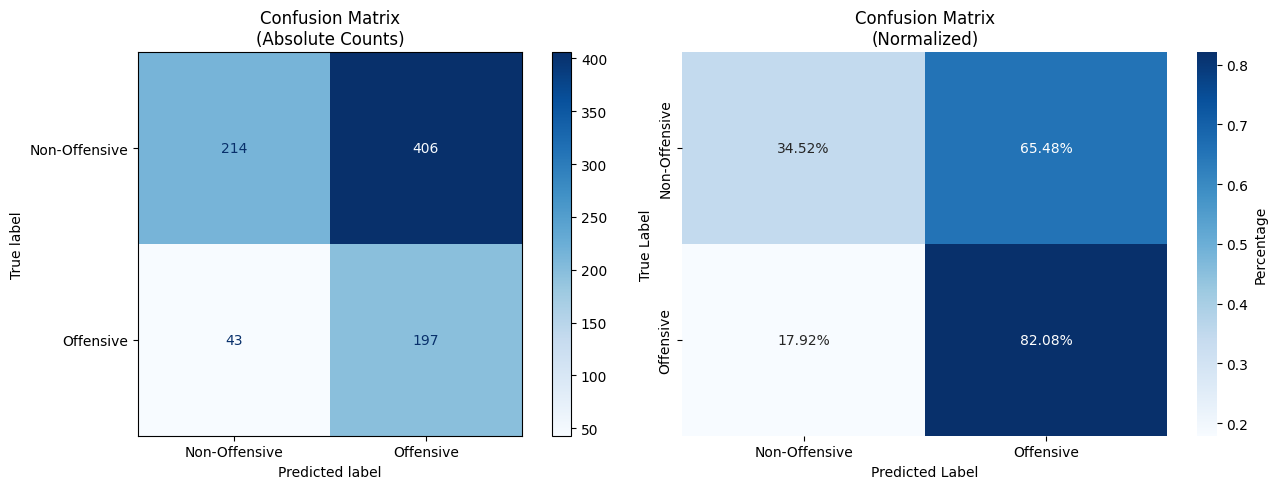

In [10]:
# OLID TESTING
y_pred_test_hasoc = svm_hasoc.predict(X_test_hasoc.values)
pd.DataFrame(y_pred_test_hasoc).describe()
metrics_hasoc = evaluate_model(y_test_hasoc, y_pred_test_hasoc, class_names=['Non-Offensive', 'Offensive'], label='hasoc')

Training SVM:   0%|          | 0/2000 [00:00<?, ?it/s]

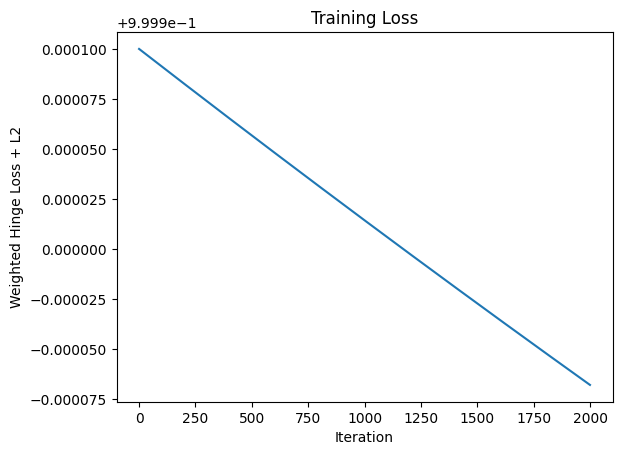

Accuracy: 0.58
Macro F1:    0.5805
Weighted F1: 0.5827


In [ ]:
# HASOC Fit
svm_hasoc = SVM(learning_rate=0.0001, lambda_param=0.1, n_iters=5000, random_state=42)
svm_hasoc.fit(X_train_hasoc.values, y_train_hasoc.values)

y_pred_hasoc = svm_hasoc.predict(X_val_hasoc.values)
pd.DataFrame(y_pred_hasoc).describe()

# plot loss
plt.plot(svm_hasoc.losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Weighted Hinge Loss + L2')
plt.show()

# eval on validation data
accuracy_hasoc = np.mean(y_pred_hasoc == y_val_hasoc.values)
print(f"Accuracy: {accuracy_hasoc:.2f}")

from sklearn.metrics import f1_score

f1_macro_hasoc = f1_score(y_val_hasoc, y_pred_hasoc, average='macro')
f1_weighted_hasoc = f1_score(y_val_hasoc, y_pred_hasoc, average='weighted')

print(f"Macro F1:    {f1_macro_hasoc:.4f}")
print(f"Weighted F1: {f1_weighted_hasoc:.4f}")

EVALUATION METRICS

Overall Accuracy: 0.4779

CLASSIFICATION REPORT
               precision    recall  f1-score   support

Non-Offensive     0.8327    0.3452    0.4880       620
    Offensive     0.3267    0.8208    0.4674       240

     accuracy                         0.4779       860
    macro avg     0.5797    0.5830    0.4777       860
 weighted avg     0.6915    0.4779    0.4823       860

MACRO-AVERAGED METRICS
Macro-Averaged Precision: 0.5797
Macro-Averaged Recall:    0.5830
Macro-Averaged F1-Score:  0.4777

PER-CLASS METRICS

Non-Offensive:
  Precision: 0.8327
  Recall:    0.3452
  F1-Score:  0.4880
  Support:   620

Offensive:
  Precision: 0.3267
  Recall:    0.8208
  F1-Score:  0.4674
  Support:   240

CONFUSION MATRIX
[[214 406]
 [ 43 197]]

Interpretation:
  True Negatives (TN):  214
  False Positives (FP): 406
  False Negatives (FN): 43
  True Positives (TP):  197

Confusion matrix for hasoc saved as 'confusion_matrix_hasoc.png'


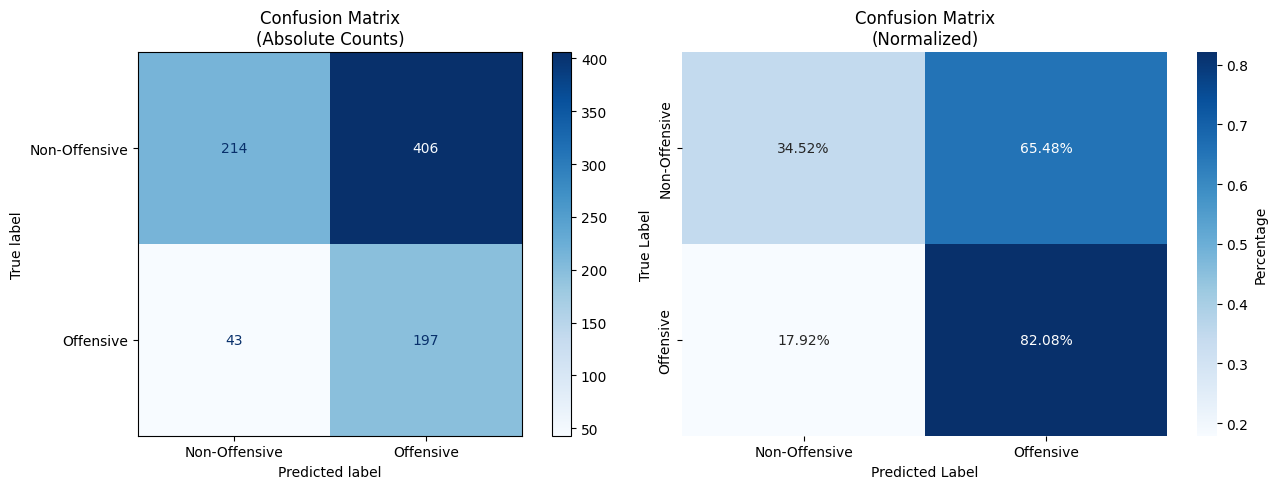

In [ ]:
# OLID TESTING
y_pred_test_hasoc = svm_hasoc.predict(X_test_hasoc.values)
pd.DataFrame(y_pred_test_hasoc).describe()
metrics_hasoc = evaluate_model(y_test_hasoc, y_pred_test_hasoc, class_names=['Non-Offensive', 'Offensive'], label='hasoc')

In [15]:
y_pred_test_hasoc

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,